<a href="https://colab.research.google.com/github/gabrielrflopes/credit_card_fraud_detection/blob/main/Detec%C3%A7%C3%A3o_de_Fraudes_em_Cart%C3%B5es_de_Cr%C3%A9dito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecção de Fraudes em Cartões de Crédito

## Importando as Bibliotecas

In [1]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Análise e visualização de dados
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

# Definindo o estilo do plot no Matplotlib e Seaborn
plt.style.use('ggplot')
sns.set_style('dark')

# Filtrar avisos 
import warnings
warnings.filterwarnings('ignore')

## Importando os Dados

### Contexto dos dados

É importante que empresas de cartões de crédito sejam capazes de identificar e diferenciar transações fraudulentas daquelas não-fraudulentas, de modo que seus clientes não sejam cobrados por compras que não fizeram.

O conjunto de dados utilizado neste projeto consiste de transações realizadas na Europa em setembro de 2013, correspondendo a dois dias de coleta de dados e um total de 284807 transações.

### Divisão dos dados

Para este projeto, vamos importar os dados em um DataFrame e, então, separaremos desse conjunto original um fração de 20% que será voltada para os testes, depois que o modelo estiver implementado. Isso irá garantir que o modelo se depare com novos exemplos, depois de ter sido construído pelos dados de treino e validado pelos *holdout set*, ou dados de retenção.

Os dados de retenção são tratam-se de subconjuntos de validação reservados que garantirão um nível de generalização no modelo, para que ele consiga lidar posteriormente com novos casos nunca antes observados. Dessa forma, ao final do projeto, teremos métricas mais confiáveis para avaliar o modelo, controlando o grau de sobreajuste a um nível aceitável e observando se de fato ele é capaz de detectar padrões de fraude.

In [3]:
data_path = 'https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1'

# Importando os dados a partir do data_path
df = pd.read_csv(data_path, delimiter = ',')

print('Dimensões do dataset original:',
      '\n----------------------------'
      '\nEntradas:\t', df.shape[0],
      '\nVariáveis:\t', df.shape[1],
      '\n----------------------------')

# Criando um subconjunto de teste para ser reservado ao final
test = df.sample(frac = 0.2, random_state = 0)

# Excluindo as entradas correspondentes ao subconjunto de teste
df = df.drop(test.index)

df.head()

Dimensões do dataset original: 
----------------------------
Entradas:	 284807 
Variáveis:	 31 
----------------------------


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Dicionário de variáveis

- `Time` - Tempo transcorrido desde o início da coleta de dados;
- `Amount` - Quantidades das transações;
- `Class` - Variável-alvo que define se uma transação foi fraudulenta ou não: **Normal = 0**, **Fraude = 1**;
- `(V1, V2, …, V28)` - Valores que caracterizam as transações, obtidos a partir da transformação PCA, uma técnica de redução de dimensionalidade que visa, nesse contexto, preservar dados de confidencialidade. 

### Particularidades dos atributos

Uma particularidade dos atributos é que a maioria passou por um processo de transformação e descaracterização dos valores por Análise de Componentes Principais (ou PCA, em inglês).

PCA (Principal Component Analysis) é um método estatístico que envolve transformar um conjunto de atributos em um conjunto menor de variáveis não-correlacionadas, conhecidas como componentes principais. Estas capturam as informações mais importantes - a variabilidade - do conjunto de dados, enquanto cria uma representação de menor dimensão dos dados.

No contexto do uso para dados de transações de cartões de crédito, o PCA resulta em componentes principais que são combinações lineares das variáveis originais. O processo visa maximizar a variabilidade dos dados, preservando características estatísticas gerais, enquanto minimiza o risco de exposição de dados sensíveis, como identidade do comprador e detalhes específicos das transações.

Dessa forma, fica garantido que todos os dados são confidenciais, ainda que possam providenciar insights valiosos à respeito de padrões de uso dos cartões de crédito e potenciais fraudes.

Neste _dataset_, apenas as variáveis `Time`, `Amount` e `Class` não passaram por essa transformação. O restante dos atributos $V1, V2, …, V28$ apresentam como valores numéricos os resultados do PCA.

Como esse procedimento de Análise de Componentes Principais é sensível à escala das variáveis, assume-se que as _features_ originais foram apropriadamente padronizadas antes de serem submetidas à técnica de redução de dimensionalidade via PCA.

## Objetivos do projeto

Neste projeto, buscamos analisar os dados das transações visando construir um modelo de Machine Learning que seja capaz de prever fraudes para novos dados de forma efetiva.

Para isso, é necessário que:

- Seja feita uma análise exploratória visando conhecer a distribuição e características gerais dos dados;
- O conjunto de dados seja balanceado, de modo que o modelo resultante saiba identificar corretamente os padrões que representam transações normais e fraudulentas;
- O modelo seja treinado utilizando métodos de classificação e otimização que garantam o equilíbrio com relação a sobreajustes e à generalização para novos dados, de modo a manter a complexidade em um grau aceitável.

Em resumo, iremos:

- Entender as distribuições e padrões que os dados oferecem;
- Balancear os dados meio a meio com exemplos de transações legítimas e fraudulentas;
- Determinar os modelos de classificadores que serão utilizados;
- Ajustar os dados de treino para construção do modelo, e testá-lo no conjunto de testes;
- Comparar o desempenho de cada modelo;

## Análise Exploratória



A análise exploratória inicial tem como objetivo uma visão geral das dimensões do _dataset_, dos tipos das variáveis, além do tratamento de valores nulos e do cálculo de proporções entre os casos de transações classificadas como fraude e legítimas.

Em seguida, iremos visualizar as variáveis `Time`e `Amount`, buscando padrões identificáveis das classes da variável-alvo que já se manifestam.

#### **Dimensões do conjunto de dados**

In [4]:
print('Dimensões do dataset de treino',
      '\n----------------------------',
      '\nEntradas:\t', df.shape[0],
      '\nVariáveis:\t', df.shape[1],
      '\n----------------------------')

print('Dimensões do dataset de teste',
      '\n---------------------------',
      '\nEntradas:\t', test.shape[0],
      '\nVariáveis:\t', test.shape[1],
      '\n---------------------------')

Dimensões do dataset de treino 
---------------------------- 
Entradas:	 227846 
Variáveis:	 31 
----------------------------
Dimensões do dataset de teste 
--------------------------- 
Entradas:	 56961 
Variáveis:	 31 
---------------------------


#### **Nomes das variáveis**

In [5]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

#### **Tipos das variáveis**

In [6]:
df.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227846 entries, 0 to 284806
Columns: 31 entries, Time to Class
dtypes: float64(30), int64(1)
memory usage: 55.6 MB


In [7]:
print('O dataset possui 30 variáveis do tipo float64 e uma variável do tipo int64')

O dataset possui 30 variáveis do tipo float64 e uma variável do tipo int64


#### **Valores nulos**

In [8]:
nan = (df.isna().sum() / df.__len__() * 100).max()

if nan == 0.0:
  print('O dataset não possui valores ausentes.')
else:
  print(df.isna().sum() / df.__len__() * 100)

O dataset não possui valores ausentes.


#### **Sumário Estatístico**

In [9]:
df.describe().round(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,227846.00,227846.00,227846.00,227846.00,227846.00,227846.00,227846.00,227846.00,227846.00,227846.00,...,227846.00,227846.00,227846.00,227846.00,227846.00,227846.00,227846.00,227846.00,227846.00,227846.00
mean,94832.50,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,...,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,88.63,0.00
std,47500.75,1.96,1.65,1.52,1.42,1.37,1.33,1.23,1.21,1.10,...,0.74,0.73,0.62,0.61,0.52,0.48,0.40,0.32,248.04,0.04
min,0.00,-46.86,-63.34,-33.68,-5.68,-42.15,-23.50,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.82,-10.30,-2.60,-22.57,-11.71,0.00,0.00
25%,54202.25,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.69,0.00
50%,84738.50,0.02,0.06,0.18,-0.02,-0.06,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139337.00,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.60,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.10,23.92,44.05,20.01,15.59,...,27.20,10.50,22.53,4.02,7.52,3.46,12.15,22.62,19656.53,1.00


#### **Distribuição e proporção da variável-alvo**

In [10]:
df['Class'].value_counts()

0    227455
1       391
Name: Class, dtype: int64

In [11]:
# Calculando a porcentagem de transações fraudulentas e legítimas
fraud_pct = df['Class'].loc[df['Class'] == 1].sum() / df.shape[0] * 100
non_fraud_pct = df['Class'].loc[df['Class'] == 0].shape[0] / df.shape[0] * 100 

In [12]:
print(f'Transações não-fraudulentas:\t{non_fraud_pct:.2f}% do total de transações')
print(f'Transações fraudulentas:\t{fraud_pct:.2f}% do total de transações')

Transações não-fraudulentas:	99.83% do total de transações
Transações fraudulentas:	0.17% do total de transações


### Visualização dos dados

In [13]:
#@title
# Definindo as cores que serão utilizadas nos gráficos
darkblue = '#071a52'
darkred = '#85203b'
blue_legit = '#1f4287'
red_fraud = '#ff304f'
text = '#303a52'

#### **Desbalanceamento dos dados**

Utilizando o `countplot` da biblioteca `Seaborn`, vamos visualizar o quão desbalanceados estão os dados. Já vimos a desproporcionalidade entre transações legítimas e fraudulentas, com a primeira representando 99,83% e a última apenas 0,17% do _dataset_.

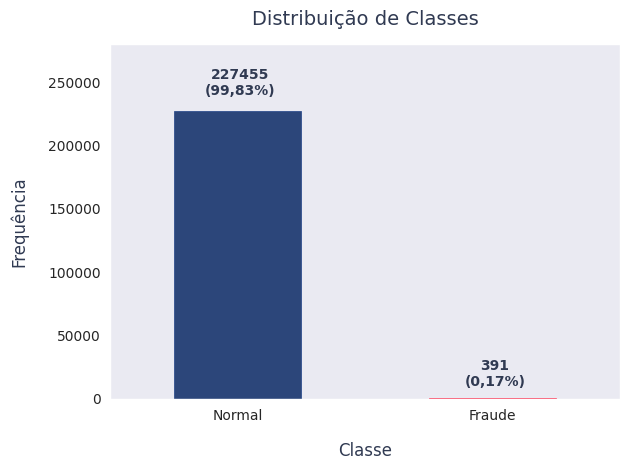

In [14]:
fig, ax = plt.subplots()

sns.countplot(df, x = df['Class'], palette = [blue_legit, red_fraud], width = 0.5, edgecolor = [blue_legit, red_fraud])

ax.set_xticklabels(['Normal', 'Fraude'])
ax.set_xlabel('Classe', color = text, fontsize = 12, fontweight = 'medium', labelpad = 14)
ax.set_ylabel('Frequência', color = text, fontsize = 12, fontweight = 'medium', labelpad = 14)
ax.set_title('Distribuição de Classes', fontsize = 14, fontweight = 'medium', pad = 14, color = text)
ax.set_ylim(0, 280000)

ax.text(0.01, 240000, '227455\n(99,83%)', color = text, fontweight = 'heavy', horizontalalignment = 'center')
ax.text(1.01, 10000, '391\n(0,17%)', color = text, fontweight = 'heavy', horizontalalignment = 'center')

fig.tight_layout()
fig.show()

In [15]:
print('Tipos de transações',
      '\n----------------------',
      '\nLegítimas:\t', df['Class'].value_counts()[0],
      '\nFraudulentas:\t', df['Class'].value_counts()[1],
      '\n----------------------')

Tipos de transações 
---------------------- 
Legítimas:	 227455 
Fraudulentas:	 391 
----------------------


O gráfico acima mostra claramente o desbalanceamento dos dados, com a frequência das classes disposta no eixo Y. 

Para que nosso modelo seja preciso o suficiente para identificar novos casos de fraude, é preciso balancear os dados com o mesmo número de exemplos para as duas classes. Se utilizarmos um conjunto de dados desbalanceado como base, teremos muitos erros e o modelo provavelmente irá sobreajustar a grande maioria dos exemplos, uma vez que irá assumir que a maioria dos casos não são fraudes.

Queremos que o modelo detecte padrões que deem sinais de fraude e, por isso, ele será balanceado mais a frente.

#### **Distribuições das classes ao longo do tempo**

Em seguida, queremos visualizar a distribuição da frequência das transações para cada classe da variável-alvo. Queremos ver se o tempo é um atributo informativo capaz de comunicar padrões que o modelo será capaz de identificar.

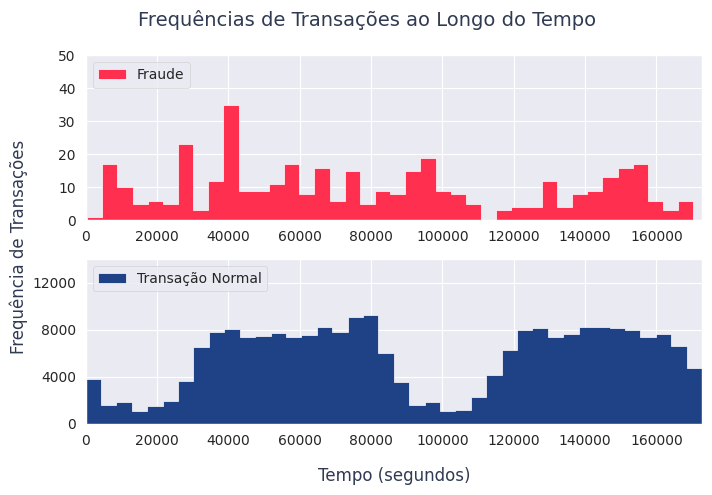

In [16]:
fig, ax = plt.subplots(2, 1, figsize = (7, 5))

df['Time'].loc[df['Class'] == 1].hist(ax = ax[0], bins = 40, histtype = 'stepfilled', color = red_fraud, label = 'Fraude')
df['Time'].loc[df['Class'] == 0].hist(ax = ax[1], bins = 40, histtype = 'stepfilled', color = blue_legit, label = 'Transação Normal')

# ax[0].set_ylabel('Frequência de transações', fontsize = 12, fontweight = 'medium')
ax[0].set_xlim(df['Time'].min(), df['Time'].max())
ax[0].set_ylim(0, 50)
ax[0].legend(loc = 'upper left', fontsize = 'medium')


ax[1].set_xlabel('Tempo (segundos)', fontweight = 'medium', labelpad = 14, color = text)
# ax[1].set_ylabel('Frequência de transações', fontsize = 12, fontweight = 'medium', labelpad = 14)
ax[1].set_xlim(df['Time'].min(), df['Time'].max())
ax[1].set_yticks(ticks = [0, 4000, 8000, 12000], labels = ['0', '4000', '8000', '12000'])
ax[1].set_ylim(0, 14000)
ax[1].legend(loc = 'upper left', fontsize = 'medium')

fig.text(-0.01, 0.3, 'Frequência de Transações', rotation = 'vertical', color = text, fontsize = 12, fontweight = 'medium')
fig.suptitle('Frequências de Transações ao Longo do Tempo', fontsize = 14, fontweight = 'medium', color = text)
fig.tight_layout()
fig.show()

O gráfico acima mostra a frequência de transações ao longo de dois dias, para casos de fraude (em vermelho) e normais (em azul). Note que os normais ocorrem com certa periodicidade, e o plateau representa os horários comuns (normalmente comerciais) em que as compras ocorreram.

Por outro lado, as transações fraudulentas não apresentam um padrão definido de horários, inclusive acontecendo com mais frequência em períodos fora do horário convencional em que as pessoas fazem compras.

#### **Frequência relativa das distribuições com relação ao tempo, usando o estimador gaussiano**

Para ter mais insights com relação a isso, o gráfico a seguir mostra a frequência relativa das mesmas distribuições, juntamente com um gráfico de linha obtido a partir do cálculo do estimador gaussiano aplicado à variável `Time`.

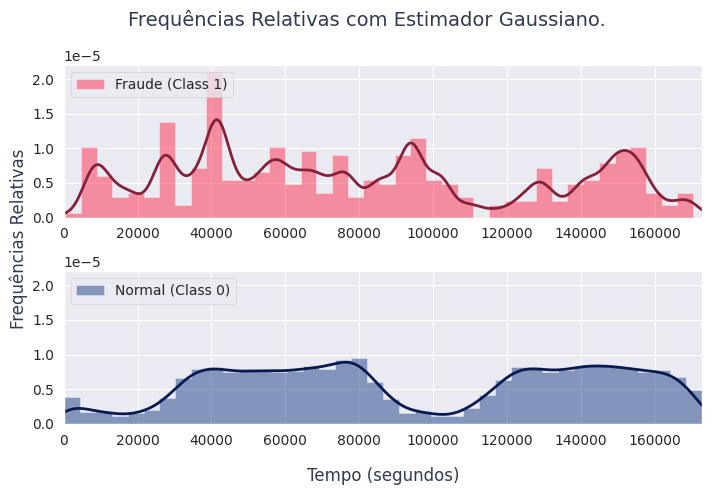

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

fig, ax = plt.subplots(2, 1, figsize = (7, 5))

# Plotando os histogramas
df['Time'].loc[df['Class'] == 1].hist(ax = ax[0], bins = 40, density = True, histtype = 'stepfilled', color = red_fraud, label = 'Fraude (Class 1)', alpha = 0.5)
df['Time'].loc[df['Class'] == 0].hist(ax = ax[1], bins = 40, density = True, histtype = 'stepfilled', color = blue_legit, label = 'Normal (Class 0)', alpha = 0.5)

# Plotando as linhas seguindo as distribuições, usando o estimador de densidade gaussiano através da função gaussian_kde
x = np.linspace(df['Time'].min(), df['Time'].max(), 1000)
y1 = gaussian_kde(df['Time'].loc[df['Class'] == 1], bw_method = 0.065)(x)
y2 = gaussian_kde(df['Time'].loc[df['Class'] == 0])(x)
ax[0].plot(x, y1, color = darkred, linewidth = 2)
ax[1].plot(x, y2, color = darkblue, linewidth = 2)

# Manipulando os Axes
ax[0].set_xlim(df['Time'].min(), df['Time'].max())
ax[0].set_ylim(0, 0.000022)
ax[0].legend(loc = 'upper left', fontsize = 'medium')

ax[1].set_xlabel('Tempo (segundos)', fontweight = 'medium', labelpad = 14, color = text)
ax[1].set_xlim(df['Time'].min(), df['Time'].max())
ax[1].set_ylim(0, 0.000022)
ax[1].legend(loc = 'upper left', fontsize = 'medium')

fig.text(-0.01, 0.35, 'Frequências Relativas', rotation = 'vertical', color = text, fontsize = 12, fontweight = 'medium')
fig.suptitle('Frequências Relativas com Estimador Gaussiano.', fontsize = 14, fontweight = 'medium', color = text)
fig.tight_layout()
fig.show()

Note como a curva gaussiana do estimador de densidade não consegue acompanhar a variabilidade dos dados para o caso com fraude. Apesar disto não ser uma informação que determina a fraude, é algo interessante de notar e comparar com o caso normal, onde a curva gaussiana consegue se ajustar à distribuição das transações.

#### **Analisando as distribuições dos valores das transações**

O gráfico abaixo mostra a distribuição dos valores das transações, comparando os casos normais com os fraudulentos numa escala de frequência relativa. Note que deixamos os intervalos dos eixos iguais, para melhorar a visualização das particularidades entre as classes.

array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035,
       0.004 , 0.0045])

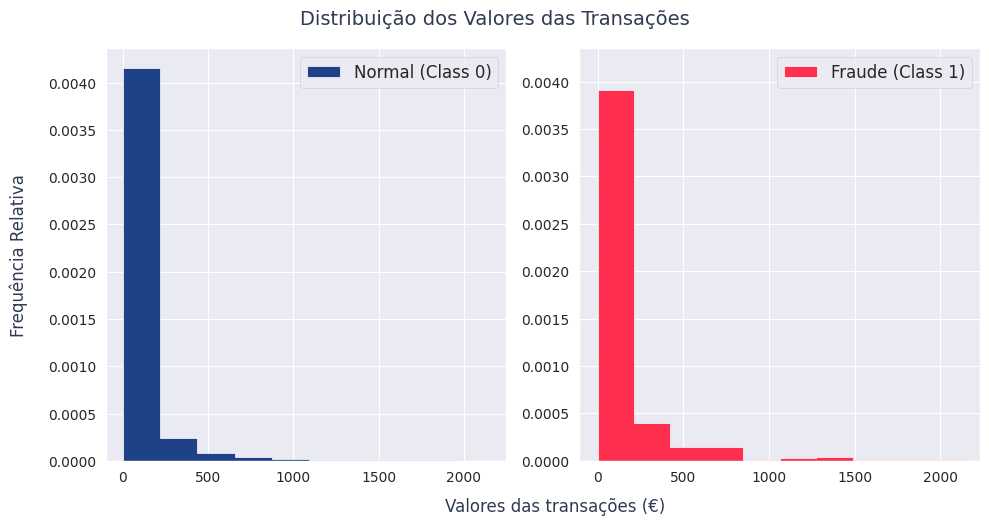

In [18]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

df['Amount'].loc[df['Class'] == 0].hist(ax = ax[0], histtype = 'stepfilled', color = blue_legit, label = 'Normal (Class 0)', bins = 90, density = True)
df['Amount'].loc[df['Class'] == 1].hist(ax = ax[1], histtype = 'stepfilled', color = red_fraud, label = 'Fraude (Class 1)', density = True)

ax[0].set_ylabel('Frequência Relativa', fontsize = 12, color = text, labelpad = 14)
ax[0].set_xlim(-100, 2250)
ax[0].set_xticks(ticks = [0, 500, 1000, 1500, 2000], labels = ['0', '500', '1000', '1500', '2000'])
ax[0].legend(fontsize = 'large')

ax[1].set_ylim(0, 0.00435)
ax[1].legend(fontsize = 'large')

fig.suptitle('Distribuição dos Valores das Transações', fontsize = 14, color = text, ha = 'center', )
fig.text(0.45, -0.025, 'Valores das transações (€)', fontsize = 12, color = text)
fig.tight_layout()
fig.show()

ax[0].get_yticks()

Note que, para transações normais, os valores se acumulam principalmente no primeiro intervalo, se distribuindo até por volta de € 1000, mas numa frequência bem menor. 

Para transições fraudulentas, note que a maioria também se acumula em valores do primeiro intervalo, menores que € 250. Porém, para valores mais altos, a proporção de transações já é ligeiramente maior, principalmente para valores entre € 250 e € 1500.

Espera-se que nosso modelo seja capaz de apurar esse tipo de padrão, caso ele seja de fato indicativo de fraude, como parece ser a partir dessa análise.

#### **Visualizando as tendências estatísticas nos valores de transação com o boxplot**

In [19]:
amount_legit = df['Amount'].loc[df['Class'] == 0]
amount_fraud = df['Amount'].loc[df['Class'] == 1]

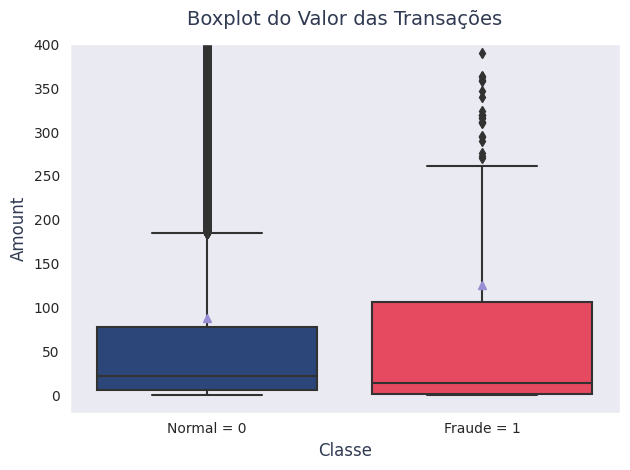

In [20]:
fig, ax = plt.subplots()

sns.boxplot(data = df, x = df['Class'], y = df['Amount'], palette = [blue_legit, red_fraud], showmeans = True)

ax.set_xlabel('Classe', fontsize = 12, color = text)
ax.set_ylabel('Amount', fontsize = 12, color = text)
ax.set_xticklabels(labels = ['Normal = 0', 'Fraude = 1'])
ax.set_ylim(-20, 400)
ax.set_title('Boxplot do Valor das Transações', fontsize = 14, pad = 14, color = text)

fig.tight_layout()
fig.show()

Os boxplots acima mostram algumas diferenças estatísticas entre as classes com relação à variável `Amount`. Note que as transações normais apresentam média menor e  uma mediana maior com relação aos casos de fraude.

Além disso, quando comparado com a classe de fraude, o intervalo entre quartis (IQR) para a classe normal é menor, assim como os valores máximos do limite superior do IQR.

Por fim, o fato de haver muitos _outliers_ para essas variáveis significa que devemos fazer algum tipo de normalização sensível a outliers para esses dados.

- **Comparação dos sumários estatísticos da variável `Amount` para as duas classes**

In [21]:
# Imprimindo as descrições estatísticas da variável amount para o caso normal e de fraude.
print('Normal = 0:\n\n',
      amount_legit.describe().round(2),
      '\n')

print('-' * 20)

print('\nFraude = 1:\n\n',
      amount_fraud.describe().round(2))

Normal = 0:

 count    227455.00
mean         88.57
std         248.01
min           0.00
25%           5.74
50%          22.00
75%          77.50
max       19656.53
Name: Amount, dtype: float64 

--------------------

Fraude = 1:

 count     391.00
mean      125.64
std       263.66
min         0.00
25%         1.00
50%        14.46
75%       106.27
max      2125.87
Name: Amount, dtype: float64


#### **Correlação entre as componentes principais**

A seguir, nosso objetivo é criar uma visualização das correlações entre as componentes principais, através do plot da Estimativa de Densidade Kernel (KDE) para as duas classes da variável-alvo.

A Estimativa de Densidade Kernel é uma maneira não-paramétrica de estimar a função densidade de probabilidade de uma variável aleatória. No contexto de detecção de anomalias no uso cartões de crédito, a KDE é útil para visualizar e comparar a distribuição de diferentes variáveis, como a quantidade de dinheiro gasto por transação ou a frequência das transações, por exemplo.

Uma razão pela qual a KDE ajuda neste contexto de dados é que ela pode identificar padrões incomuns que podem ser indicativos de atividade fraudulenta. Ao estimar a distribuição de probabilidade subjacente de uma dada variável, nós podemos identificar valores que são significativamente diferentes do restante dos dados. Os _outliers_, por exemplo, podem ser anomalias em potencial que requerem mais investigações.

A KDE também pode ser utilizada para visualizar e comparar distribuições através de diferentes períodos de tempo ou grupos de transações, que é o nosso caso ao comparar as duas classes da variável-alvo. Ao sobrepor os plots da KDE, é possível identificar rapidamente variações na distribuição subjacente que pode ser indicativo de uma mudança nos padrões ou no comportamento.

Aplicada às componentes principais, podemos estimar, portanto, a distribuição de probabilidade do conjunto de dados em um espaço de menor dimensão. Por exemplo, podemos identificar regiões de alta densidade da classe que determina fraude e que distoa da distribuição para a classe normal. Isto pode ser indicativo de que aquele atributo é mais informativo para previsão de fraudes.

Nos códigos a seguir, vamos preparar os dados para plotar os gráficos da KDE. Primeiro, vamos separar os índices das colunas e criar DataFrames filtrados para as classes `Normal = 0` e `Fraude = 1`da variável-alvo.

In [22]:
# Separando as colunas de componentes principais
pc_columns = df.drop(columns = ['Time', 'Amount', 'Class'], axis = 1).columns
# Número de plots que quero automatizar
num_plots = len(pc_columns)
# Selecionar todas as entradas do dataframe cujo valor da variável-alvo é 0
normal_class = df[df['Class'] == 0]
# Selecionar todas as entradas do dataframe cujo valor da variável-alvo é 1
fraud_class = df[df['Class'] == 1]

In [23]:
# Visualizando a lista das colunas com componentes principais
print(pc_columns.tolist())
print(type(pc_columns))

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']
<class 'pandas.core.indexes.base.Index'>


In [24]:
# Visualizando o dataframe criado para a classe normal = 0
normal_class.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [25]:
# Visualizando o dataframe filtrado para a classe fraude = 1
fraud_class.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.0,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.0,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.0,1


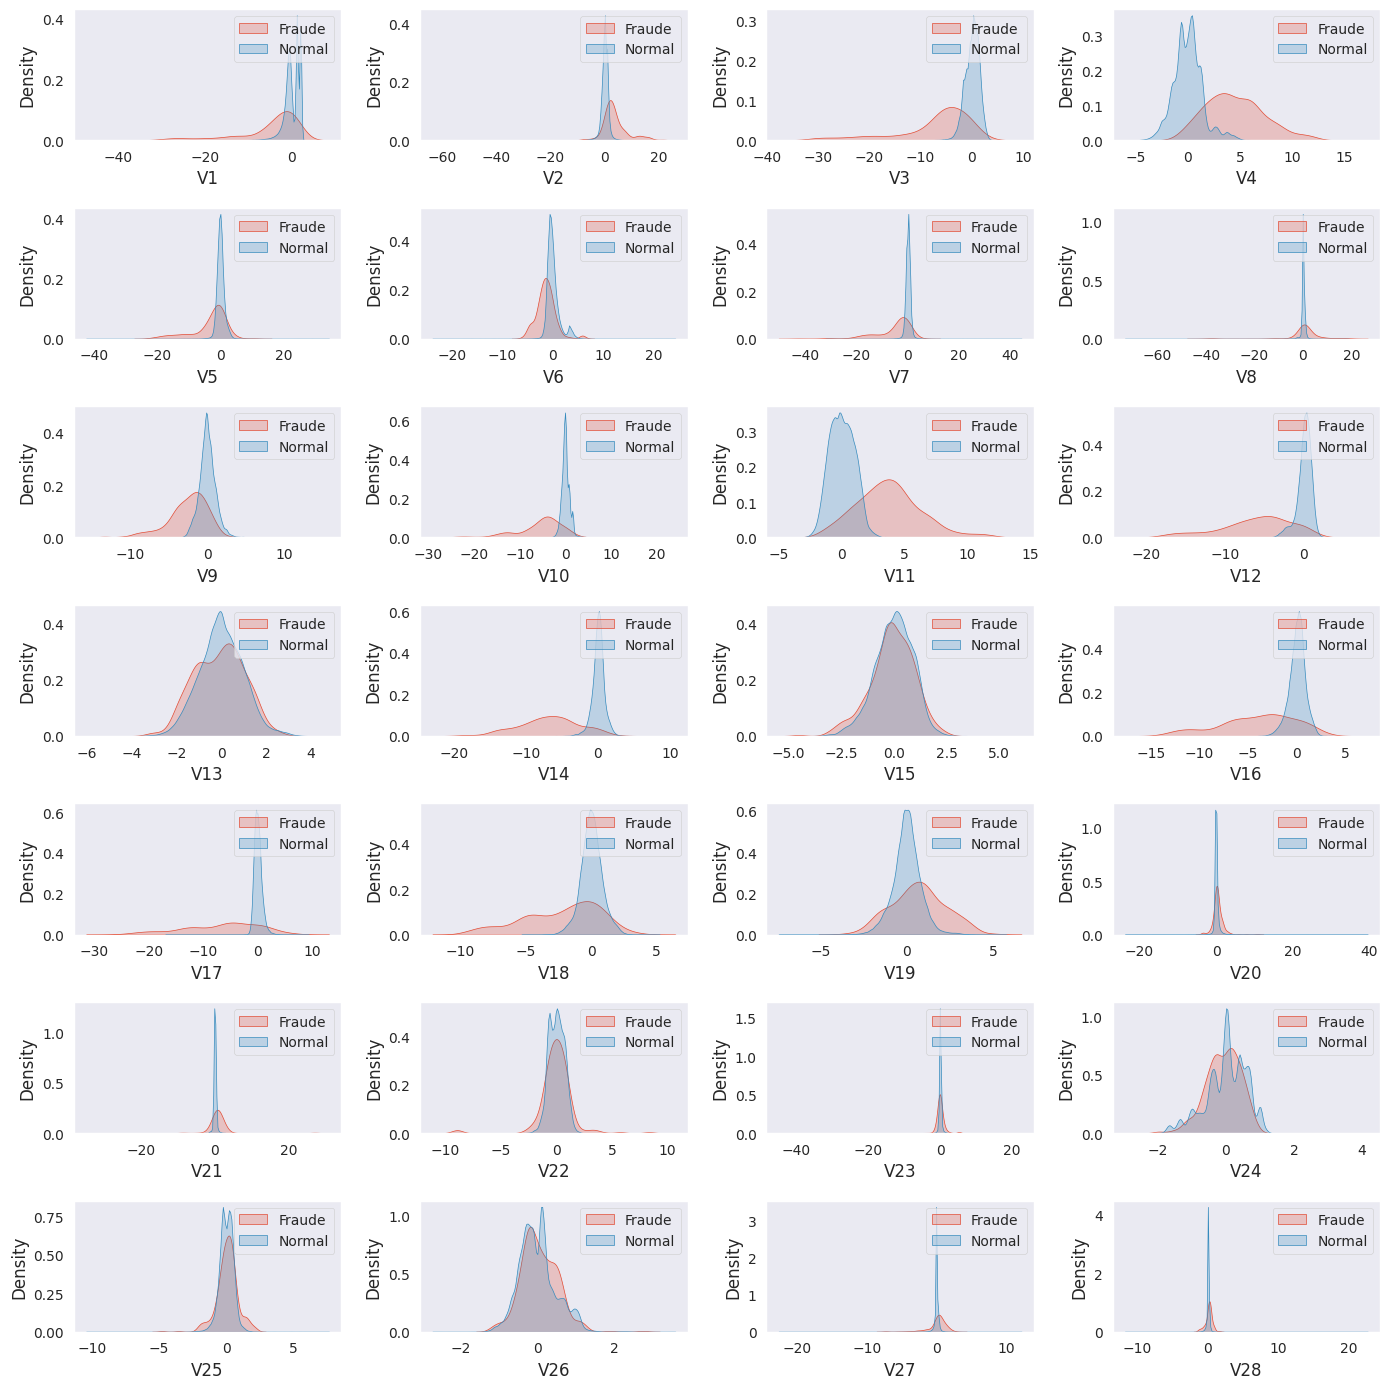

In [26]:
fig, ax = plt.subplots(7, 4, figsize = (14, 14))
# Ajustar os espaçamentos entre os subplots
fig.subplots_adjust(hspace = 1, wspace = 1)

# Definir variável iterável
idx = 0

# Loop para criação dos subplots
for col in pc_columns:
  idx += 1
  plt.subplot(7, 4, idx)
  # Plotando a distribuição de estimador de densidade kernel com seaborn
  sns.kdeplot(fraud_class[col], label = 'Fraude', fill = True)
  sns.kdeplot(normal_class[col], label = 'Normal', fill = True)
  plt.legend(loc = 'best')

fig.tight_layout()
fig.show()

A partir da análise dos gráficos acimas, podemos distinguir aquelas variáveis em que as classes tem uma maior correspondência, daquelas em que as classes distoam o suficiente para sugerir uma atividade incomum. 

Como explicado acima, quanto maior for essa discrepância entre as probabilidades subjacentes, maiores são as chances daqueles atributos serem bons preditores de fraudes para o modelo de aprendizagem de máquina. Note que as componentes mais **discrepantes** são a $V3, V4, V10, V11, V12, V14, V16, V17$ e $V18$.

Por outro lado, as que mais estão **coincidentes** são a $V6, V13, V15, V22, V25, V26$ e $V28$.

### Resumo da Análise Exploratória

O conjunto de dados é composto de variáveis numéricas que caratacterizam transações de cartões de crédito. Os atributos passaram por uma redução de dimensionalidade através da técnica do PCA (Principal Component Analysis), com o intuito de manter o sigilo de dados e a confidencialidade a respeito dos compradores.

Apenas as variáveis `Time` e `Amount` não foram transformadas pelo PCA, mantendo suas características originais. A variável-alvo é `Class` e classifica as transações entre normais e fraudulentas.

- O conjunto de dados não possui valores nulos;
- O conjunto é altamente desbalanceado, com 99,83% de transações normais e 0,17% de fraudes;
- As variáveis `Time` e `Amount` apresentam _outliers_ que deverão ser tratados para a construção do modelo;
- Destacou-se alguns atributos mais informativos para a construção do modelo.
 

## Preparação dos Dados

Para que os dados possam alimentar o modelo de Regressão Logística que iremos construir, nesta etapa de preparação iremos:

- Padronizar as features Time e Amount, que estão em outra ordem de grandeza.
- Dividir entre dados de treino e teste
- Balancear os dados a fim de evitar uma baixa performance para a classe 1 e overfitting.

#### **Padronizar as variáveis `Amount` e `Time`**

Como vimos anteriormente, as duas variáveis apresentam _outliers_ que não queremos que influenciem na construção do modelo, enviesando qualquer tipo de identificação de padrões e posterior classificação. Por esta razão, iremos utilizar uma técnica de normalização robusta a _outliers_.

Justamente, como o próprio nome diz, queremos usar o `RobustScaler` da biblioteca `Scikit-Learn`. O `RobustScaler` usa a mediana e o IQR para normalizar os dados, de modo a lidar melhor com os valores extremos. A alternativa, que seria o `StandardScaler`, normaliza baseado nas médias e na variância da distribuição normal. Como esses parâmetros são mais sensíveis aos _outliers_, decorre que os dados resultantes do `StandardScaler` não performariam tão bem no modelo de classificação a que nos propomos nesse projeto.

In [27]:
from sklearn.preprocessing import RobustScaler

# Criando uma cópia do DataFrame limpo
df_clean = df.copy()

# Criando o objeto a partir da classe RobustScaler
rob_scaler = RobustScaler()

# Ajustar os dados de Time e Amount para a normalização robusta a outliers
df_clean['norm_time'] = rob_scaler.fit_transform(df_clean['Time'].values.reshape(-1, 1))
df_clean['norm_amount'] = rob_scaler.fit_transform(df_clean['Amount'].values.reshape(-1, 1))

# Excluindo as duas colunas não normalizadas
df_clean.drop(['Time', 'Amount'], axis = 1, inplace = True)

In [28]:
# Reposicionar as colunas das variáveis normalizadas, para as primeiras posições do DataFrame
norm_time = df_clean['norm_time']
norm_amount = df_clean['norm_amount']

df_clean.drop(['norm_time', 'norm_amount'], axis = 1,  inplace = True)

# Posicionando as colunas nas primeiras posições do dataframe
df_clean.insert(0, 'Norm_Time', norm_time)
df_clean.insert(1, 'Norm_Amount', norm_amount)

df_clean.head()

,Norm_Time,Norm_Amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-0.995346,1.774718,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.995346,-0.268530,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,-0.995334,4.959811,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,-0.995334,1.411487,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-0.995322,0.667362,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


> Variáveis `Time` e `Amount` normalizadas com sucesso!

In [29]:
df_clean[['Norm_Time', 'Norm_Amount']].describe()

,Norm_Time,Norm_Amount
count,227846.000000,227846.000000
mean,0.118565,0.926573
std,0.557948,3.449274
min,-0.995346,-0.305938
25%,-0.358681,-0.226811
50%,0.000000,0.000000
75%,0.641319,0.773189
max,1.034284,273.043109


Note que esse procedimento não zerou a média nem tornou a variância igual à 1, como faz a normalização pela distribuição normal.

#### **Dividir entre os conjuntos de treino e validação**

Em seguida, vamos prosseguir dividindo os dados já normalizados entre os conjunto de treino e validação. Para isso, iremos utilizar a função `train_test_split` que está dentro do módulo `model_selection` do `Scikit-Learn`.

O procedimento envolve, também, definir os DataFrames que contém a matriz de atributos, X, e a variável-alvo, y, que no caso se trata da classe (Normal = 0, Fraude = 1).

Por último, aplicamos a função `train_test_split`, colocando nos argumentos a matriz de atributos e a variável-alvo como inputs, e estabelecendo o tamanho da porção de teste para ser 20% do conjunto de dados original. Além disso, com os argumentos **'shuffle'** e **'stratify'**, nosso objetivo é, respectivamente, embaralhar randomicamente os dados antes da divisão e manter a proporção da variável-alvo em ambos os conjuntos de treino e validação. 

In [30]:
from sklearn.model_selection import train_test_split

# Separar os dados entre a matriz de atributos e a variável-alvo
X = df_clean.drop('Class', axis = 1)
y = df_clean['Class']

# Instanciar a função que divide os dados entre os conjunto de treino e teste, armazenando-os nas respectivas variáveis
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, shuffle = True, stratify = y)

Abaixo estão as dimensões dos novos conjuntos de treino e teste, divididos numa proporção 80/20.

In [31]:
print('Dimensões dos conjuntos de treino:',
      '\nX_train:\t', X_train.shape,
      '\ny_train:\t', y_train.shape)

Dimensões dos conjuntos de treino: 
X_train:	 (182276, 30) 
y_train:	 (182276,)


In [32]:
print('Dimensões dos conjuntos de validação:',
      '\nX_val:\t', X_val.shape,
      '\ny_val:\t', y_val.shape)

Dimensões dos conjuntos de validação: 
X_val:	 (45570, 30) 
y_val:	 (45570,)


#### **Balanceamento dos dados**

Seguindo com a preparação dos dados para o modelo, precisamos balancear o conjunto de treino para que o modelo seja capaz de detectar padrões e tomar decisões sem ser afetado por problemas de sobreajuste, enviesando os resultados para a classe majoritária. 

Em vista disso, iremos utilizar uma técnica de *undersampling*, ou seja, de redução da amostragem da classe majoritária, até que tenhamos um número equivalente de exemplos de transações normais e fraudulentas.

Abaixo, importamos a função `RandomUnderSampler` a partir do módulo `under_sampling` da biblioteca `imblearn`. O `RandomUnderSampler` remove exemplos existentes da classe majoritária, de modo que cada ponto tem a mesma probabilidade de ser removido. O *trade-off* dessa abordagem é a perda de informação por redução da amostragem na classe majoritária.

In [33]:
from imblearn.under_sampling import RandomUnderSampler

# Definindo o objeto RandomUnderSampler()
rus = RandomUnderSampler()

# Aplicando o undersampling nos conjuntos de treino da matriz de atributos e da variável-alvo
X_rus, y_rus = rus.fit_resample(X_train, y_train)

print('Dimensões do conjunto de treino após o Undersampling:',
      '\nX_rus:\t', X_rus.shape,
      '\ny_rus:\t', y_rus.shape)

Dimensões do conjunto de treino após o Undersampling: 
X_rus:	 (626, 30) 
y_rus:	 (626,)


#### **Visualizando o balanceamento dos dados**

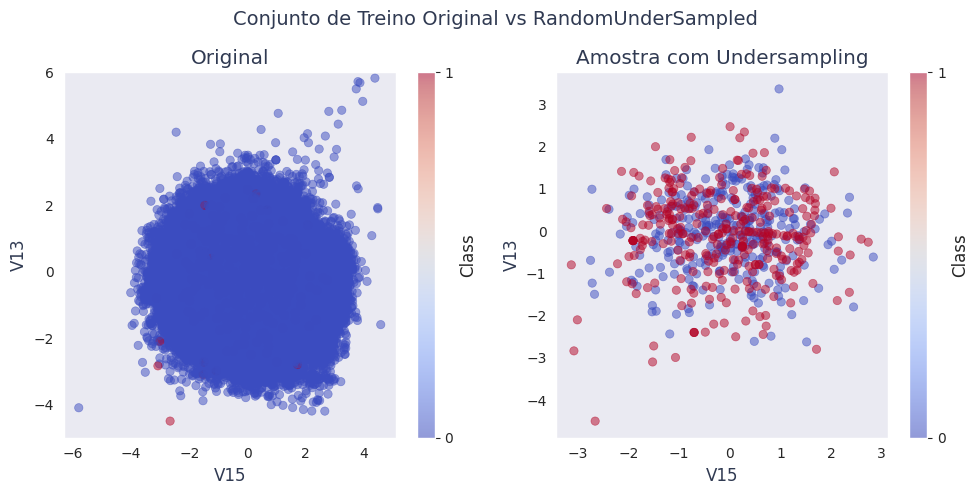

In [34]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))

# Componentes originais positivamente correlacionadas
orig_v13 = df_clean['V13']
orig_v15 = df_clean['V15']

# Amostras com undersampling das componentes correlacionadas
v13 = X_rus['V13']
v15 = X_rus['V15']

# Definindoo as variáveis que servirão para diferenciar as classes nos gráficos
Class = df_clean['Class']
Class2 = y_rus

scatter1 = ax[0].scatter(x = orig_v13, y = orig_v15, c = Class, cmap = 'coolwarm', alpha = 0.5)
fig.colorbar(scatter1, ax = ax[0], ticks = [0, 1], label = 'Class')
ax[0].set_ylabel('V13', fontsize = 12, color = text)
ax[0].set_xlabel('V15', fontsize = 12, color = text)
ax[0].set_ylim(-5, 6)
ax[0].set_title('Original', color = text)

scatter2 = ax[1].scatter(x = v13, y = v15, c = Class2, cmap = 'coolwarm', alpha = 0.5)
fig.colorbar(scatter2, ax = ax[1], ticks = [0, 1], label = 'Class')
ax[1].set_ylabel('V13', fontsize = 12, color = text)
ax[1].set_xlabel('V15', fontsize = 12, color = text)
ax[1].set_title('Amostra com Undersampling', color = text)

fig.suptitle('Conjunto de Treino Original vs RandomUnderSampled', fontsize = 14, color = text)
fig.tight_layout()
fig.show()

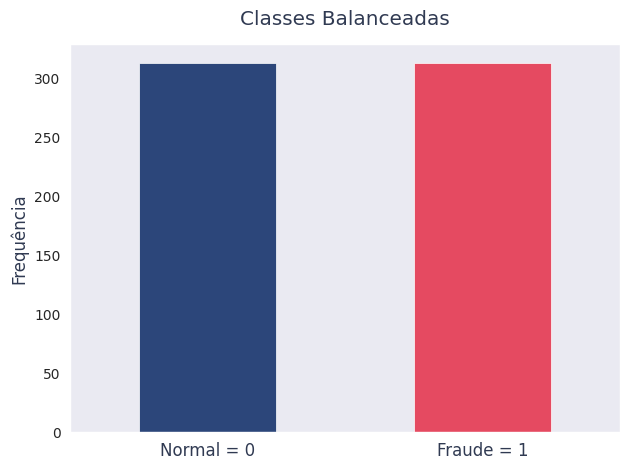

In [35]:
fig, ax = plt.subplots()

sns.countplot(x = y_rus.values, palette = [blue_legit, red_fraud], ax = ax, width = 0.5)

ax.set_title('Classes Balanceadas', pad = 14, color = text)
ax.set_ylabel('Frequência', fontsize = 12, color = text)
ax.set_xticks(ticks = [0, 1], labels = ['Normal = 0', 'Fraude = 1'], fontsize = 12, color = text)

fig.tight_layout()
fig.show()

Resumindo os procedimentos, a partir da divisão dos dados em treino e validação, nosso objetivo foi o balanceamento dos exemplos com relação às classes da variável-alvo. Para isso, utilizamos o subconjunto de treino *(X_train, y_train)* para aplicar a técnica de undersampling sobre esses dados, resultando assim no conjunto balanceado *(X_rus, y_rus)*.

#### Matriz de correlação com dados balanceados

Vamos comparar, agora, a correlação entre as componentes principais para o caso desbalanceado e balanceado.

In [36]:
corr = X_train.corr()
corr_rus = X_rus.corr()

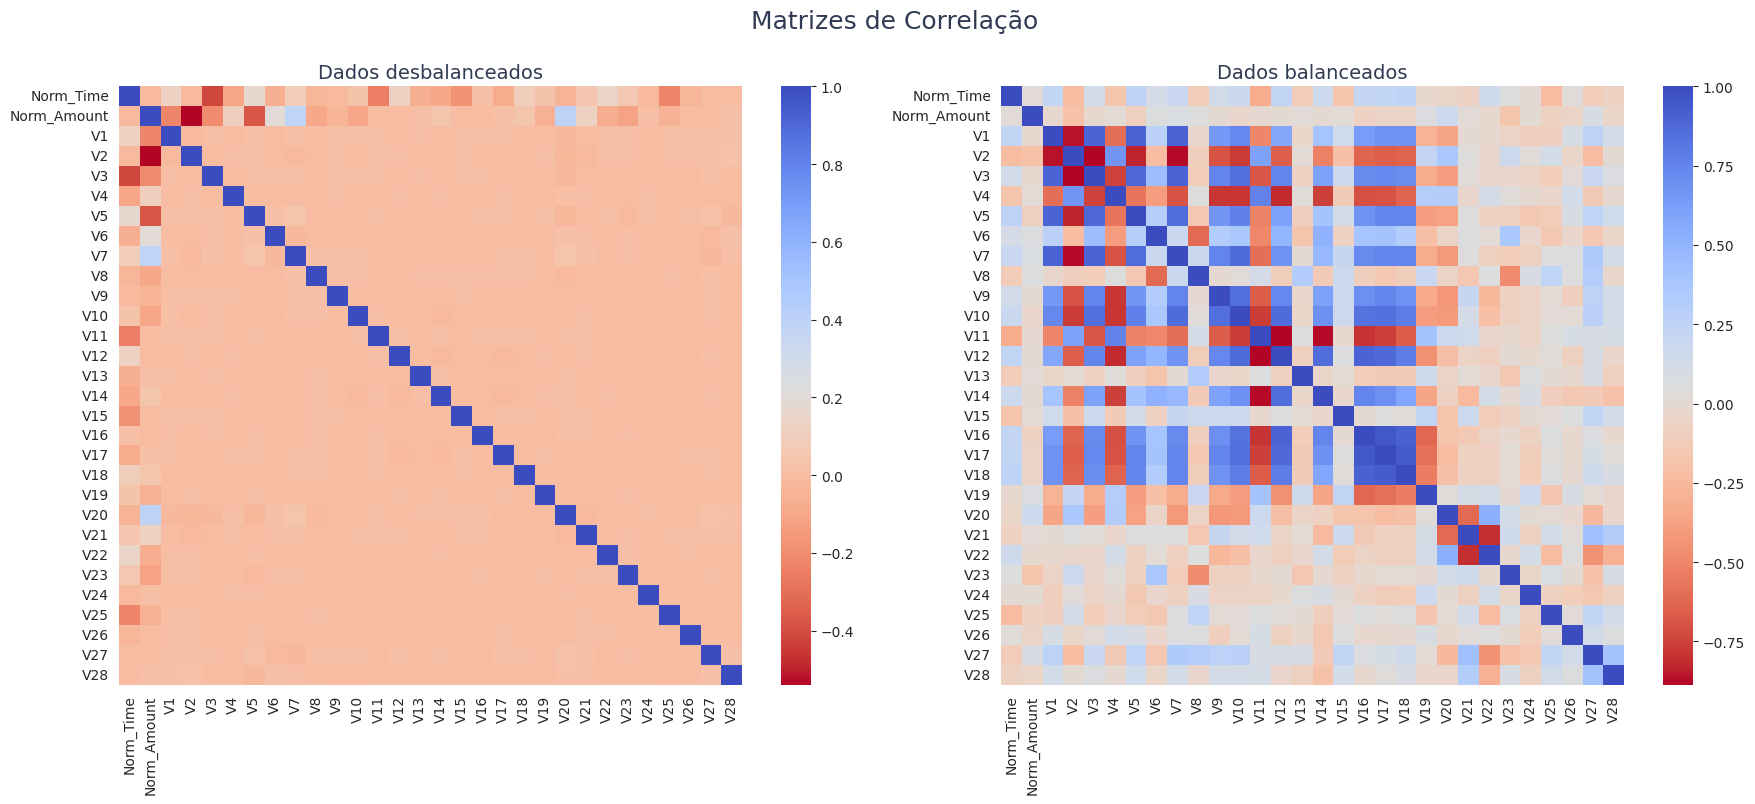

In [37]:
fig, ax = plt.subplots(1, 2, figsize = (18, 8))

sns.heatmap(corr, cmap = 'coolwarm_r', ax = ax[0], yticklabels = corr.columns, xticklabels = corr.columns, )
sns.heatmap(corr_rus, cmap = 'coolwarm_r', ax = ax[1], yticklabels = corr_rus.columns, xticklabels = corr_rus.columns)

ax[0].set_title('Dados desbalanceados', fontsize = 14, color = text)
ax[1].set_title('Dados balanceados', fontsize = 14, color = text)

fig.suptitle('Matrizes de Correlação', x = 0.5, y = 1, fontsize = 18, color = text)
fig.tight_layout()
fig.show()

À esquerda, temos a correlação dos dados desbalanceados e nota-se, claramente, a pouca relação entre as componentes principais neste caso. Isto acontece porque o número de exemplos de classe majoritária é muito maior, impedindo a detecção de padrões a partir da correlação.

Por outro lado, à direita temos a correlação com os dados balanceados. Neste caso, muitas componentes principais destacam-se pelas suas relações umas com as outras, facilitando para o modelo a detecção de padrões que podem ajudar na classificação de novos exemplos.

Agora, vamos criar nosso modelo partindo desses dados tratados.

## Construção do Modelos de Regressão Logística

Para a construção do modelo de Regressão Logística, iremos utilizar a biblioteca `Scikit-Learn` e seu módulo `linear_model`. 

A Regressão Logística é baseada na função sigmoide, e aceita relações não-lineares entre as variáveis para prever um resultado de classificação binária, que reside entre 0 e 1. A função sigmoide é definida da seguinte forma:

$$ p(x) = \frac{1}{1 - e^{-z}}, $$

em que $z$ é uma combinação linear das variáveis independentes, com seus coeficientes ajustados pelo modelo. Todo valor que a função z assume é mapeado dentro do intervalo de probabilidades definido por $p(x)$ para novas observações.

In [38]:
# Importando as bibliotecas para ajuste do modelo e avaliação de desempenho
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, log_loss
from sklearn.metrics import classification_report

Com as bibliotecas de regressão logística e as métricas para avaliar seu desempenho importadas, vamos prosseguir com a construção do modelo. Na seção anterior, já realizamos três passos importantes nesse procedimento, que foram $(1)$ a padronização das variáveis `Time` e `Amount`, $(2)$ a divisão dos dados entre treino e validação e $(3)$ o balanceamento dos subconjuntos.

Agora, iremos:

- Instanciar o modelo;
- Realizar o ajuste sobre os dados balanceados de treinamento;
- Utilizar o modelo para fazer previsões sobre os dados de validação;
- Visualizar a matriz de confusão para identificar erros;
- Avaliar o desempenho através de métricas como acurácia, precisão e AUC.

In [39]:
# Instanciar o modelo
model_1 = LogisticRegression(random_state = 42)

# Realizar o fit do modelo nos dados de treinamento balanceados
model_1.fit(X_rus, y_rus)

# Utilizar o modelo para fazer previsões com os dados de validação
y_pred_1 = model_1.predict(X_val)

# Estimar probabilidade de classe
y_proba_1 = model_1.predict_proba(X_val)

### Desempenho do modelo de Regressão Logística sobre dados balanceados de validação

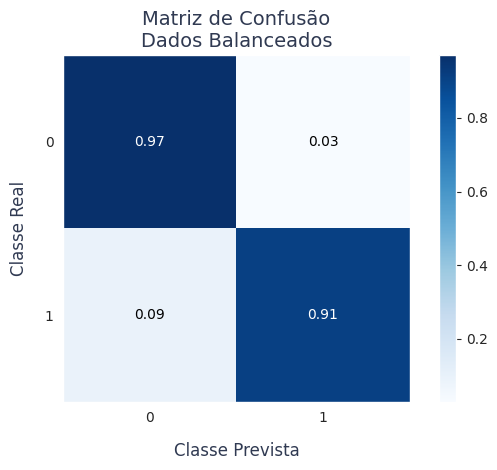

In [40]:
# Matriz de confusão
fig, ax = plt.subplots()

skplt.metrics.plot_confusion_matrix(y_val, y_pred_1, cmap = 'Blues', ax = ax, normalize = True)

ax.set_xlabel('Classe Prevista', fontsize = 12, color = text, labelpad = 12)
ax.set_ylabel('Classe Real', fontsize = 12, color = text, labelpad = 12)
ax.set_title('Matriz de Confusão\nDados Balanceados', fontsize = 14, color = text)

fig.tight_layout()
fig.show()

In [41]:
print('Número de entradas do conjunto de validação:\t', X_val.shape[0])

Número de entradas do conjunto de validação:	 45570


A partir da matriz de confusão, temos conhecimento dos erros e acertos do modelo. De modo geral, o modelo teve uma ótima taxa de acertos, prevendo corretamente 71  de 78 transações fraudulentas (91%). Na classe majoritária, como era de se esperar, ele foi ainda melhor, detectando 43754 transações normais de 45492 - uma taxa de 96%.

Entretanto, no contexto de problemas de negócios, devemos nos atentar à taxa de Falsos Positivos (FP) e Falsos Negativos (FN).

- Falsos Positivos (FP): 1738 exemplos de 45492, ou 4%;
- Falsos Negativos (FN): 7 exemplos de 78, ou 9%.

A partir desses dois erros, surgem dois problemas para a empresa de cartão de crédito. Se houver um número alto de FP, muitos cartões serão bloqueados sem haver fraude, o que pode levar a uma má experiência do usuário.

Com um número alto de FN, uma parcela dos clientes será lesada com fraudes que não foram detectadas pelo modelo, levando a perda de clientes e até problemas judiciais. 

O modelo em questão tem uma taxa baixa de FN e FP, e é a melhor escolha caso a empresa queira mitigar os efeitos dos FP e melhorar a experiência de usuário.

- **Relatório de Classificação**

Vamos avaliar as métricas de desempenho do modelo de regressão logística nos dados balanceados:

In [42]:
# Report de classificação
print('Relatório de classificação:\n\n',
      classification_report(y_val, y_pred_1, digits = 3))

# Score de acurácia do modelo
print('Acurácia:\t{:.3f}'.format(accuracy_score(y_val, y_pred_1)))

# Área sob a curva
print('\nAUC:\t\t{:.3f}'.format(roc_auc_score(y_val, y_pred_1)))

# Perda logística (Quanto mais próximo de zero, melhor)
print('\nLog Loss:\t{:.3f}'.format(log_loss(y_val, y_proba_1)))

Relatório de classificação:

               precision    recall  f1-score   support

           0      1.000     0.968     0.984     45492
           1      0.047     0.910     0.089        78

    accuracy                          0.968     45570
   macro avg      0.523     0.939     0.537     45570
weighted avg      0.998     0.968     0.982     45570

Acurácia:	0.968

AUC:		0.939

Log Loss:	0.146


O modelo teve um ótimo desempenho segundo as métricas. A acurácia alta mostra que o modelo faz uma boa previsão das classes, detectando corretamente 96% das transações e, como os dados são balanceados, essa métrica é mais confiável como indicativo do desempenho do modelo.

A AUC (*Area Under the Curve*) mede a capacidade do modelo de distinguir entre casos positivos e negativos. Ela varia de 0 a 1, sendo o valor máximo indicativo de um classificador perfeito. Neste caso, o valor de 93,6% Indica que o modelo e capaz de distinguir bem entre transações legítimas e fraudulentas.

Por último, o LogLoss (*Logistic Loss*) mostra o desempenho do modelo em termos das probabilidades de classe previstas. Quanto mais próximo de zero, melhor o desempenho do modelo e, neste caso, ele está relativamente baixo em 14,4%.

In [43]:
print('Coeficientes:\t', model_1.coef_)
print('-' * 90)
print('Intercepto (viés):\t', model_1.intercept_)

Coeficientes:	 [[-0.57407197  0.18505019  0.23302933 -0.27083626  0.00445177  0.9668019
   0.38886766 -0.50716225 -0.28675947 -0.69598486 -0.26605168 -0.70909877
   0.34967151 -0.90859384 -0.05712827 -1.08283086 -0.13892559 -0.16354041
  -0.70702471 -0.29968883  0.30404677 -0.3274624   0.23238662  0.33677302
  -0.217546    0.08225881 -0.17660525  0.09957877 -0.59097249  0.01495293]]
------------------------------------------------------------------------------------------
Intercepto (viés):	 [-3.42727979]


Por último, o intercepto mostra a probabilidade basal do modelo, ou seja, a tendência (ou viés) de classificação quando todas as outras variáveis são zero. Se o intercepto é positivo, maiores são as chances do modelo classificar um novo exemplo como sendo da classe 1, enquanto que se o intercepto for negativo, como é o caso, maiores as chances de termos exemplos classificados como classe 0.

Para um intercepto de -3.315, é possível calcular as chances de o modelo classificar um novo exemplo como sendo fraude. Para isso, utilizamos a fórmula:

$$ \frac{p}{1 - p}, $$

em que $p$ é dado por $e^{w_0}$, com $w_0$ sendo o intercepto. 

Assim, para -3.315, temos que a probabilidade basal do modelo classificar um novo exemplo como 1 é de 3,7%. Ou seja, se todas as outras variáveis forem zero, 96,3% das vezes o modelo classificará uma transação como normal.

### Modelo de Regressão Logística sobre dados desbalanceados

Para motivos de comparação, vamos construir um modelo com os dados desbalanceados e ver como se dá o seu desempenho em comparação com o primeiro. 

In [44]:
model_2 = LogisticRegression(random_state = 42)

# Ajustar o modelo sobre os dados desbalanceados, antes de passarem pelo RandomUnderSampler
model_2.fit(X_train, y_train)

# Prever os dados sobre os conjuntos de validação
y_pred_2 = model_2.predict(X_val)
# Estimar probabilidade de classe 
y_proba_2 = model_2.predict_proba(X_val)

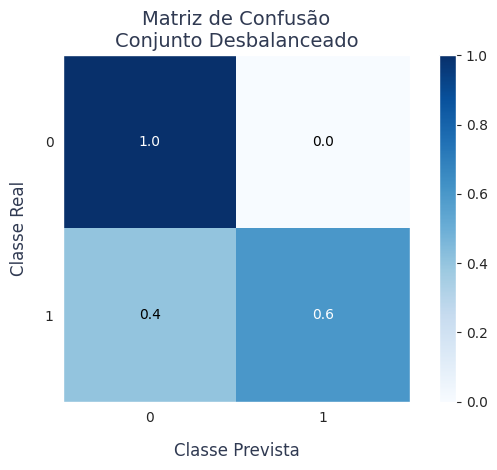

In [45]:
fig, ax = plt.subplots()

skplt.metrics.plot_confusion_matrix(y_val, y_pred_2, normalize = True, cmap = 'Blues', ax = ax)

ax.set_xlabel('Classe Prevista', fontsize = 12, color = text, labelpad = 12)
ax.set_ylabel('Classe Real', fontsize = 12, color = text, labelpad = 12)
ax.set_title('Matriz de Confusão\nConjunto Desbalanceado', fontsize = 14, color = text)

fig.tight_layout()
fig.show()

Como era de se esperar, os dados desbalanceados favorecem a classificação da classe majoritária. Pela matriz de confusão, vemos que 100% dos exemplos de classe majoritária foram classificados corretamente, o que é sinal de sobreajuste do modelo.

Para as fraudes, houveram mais Falsos Negativos (FN) com relação ao primeiro modelo, principalmente porque ele não foi capaz de distinguir os padrões de fraude a partir dos dados desbalanceados. Ainda assim, 62% das transações fraudulentas foram classificadas corretamente. 

In [46]:
print('Report de Classificação:\n\n',
      classification_report(y_val, y_pred_2))

print('Acurácia:\t{:.3f}\n'.format(accuracy_score(y_val, y_pred_2)))

print('AUC:\t\t{:.3f}'.format(roc_auc_score(y_val,y_pred_2)))

print('\nLog Loss:\t{:.3f}'.format(log_loss(y_val, y_proba_2)))

Report de Classificação:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00     45492
           1       0.85      0.60      0.71        78

    accuracy                           1.00     45570
   macro avg       0.93      0.80      0.85     45570
weighted avg       1.00      1.00      1.00     45570

Acurácia:	0.999

AUC:		0.801

Log Loss:	0.004


O relatório de classificação corrobora a análise de sobreajuste do modelo, uma vez que a acurácia é de 99,9% e a perda logística (LogLoss) é de apenas 0.004. A métrica AUC mostra corretamente que este segundo modelo é menos capaz de distinguir entre as classes positivas e negativas do que o primeiro.

In [47]:
print('Coeficientes:\t', model_2.coef_)
print('-' * 90)
print('Intercepto (viés):\t', model_2.intercept_)

Coeficientes:	 [[-0.20548602  0.09249464  0.12484566  0.043228    0.01251302  0.70967868
   0.12554817 -0.1346325  -0.16784001 -0.15157054 -0.28409997 -0.7537937
  -0.01495738  0.10032175 -0.23209009 -0.53709845 -0.13504744 -0.18888186
  -0.03942393 -0.01860364  0.05197299 -0.48134025  0.34163746  0.57429426
  -0.05193153  0.0723781  -0.05450661  0.21105652 -0.80728723 -0.25332141]]
------------------------------------------------------------------------------------------
Intercepto (viés):	 [-8.68339848]


Por último, o intercepto mais negativo que o do primeiro modelo mostra que a probabilidade basal tende mais para a classificação de transações como legítimas.

De fato, se calcularmos as chances, teremos um valor de 0.00016, ou 0.016% de chances de um novo exemplo ser classificado como fraude, dada todas as outras variáveis nulas. 

Isso mostra que os dados desbalanceados forçaram o viés do modelo para identificar a classe majoritária, resultando em um problema clássico de sobreajuste.

## Construindo o Modelo de Árvore de Decisão

Retornando para o contexto do problema de negócio, queremos construir um modelo que diminua a taxa de Falsos Negativos (FN), para servir como alternativa ao primeiro modelo.

#### **Profundidade da Árvore**

No caso dos modelos de Árvore de Decisão, é necessário definir a profundidade ótima da árvore, para que o modelo não sofra sobreajuste ao tentar subdividir os nós-folha da árvore até que eles sejam puros.

Para decidir qual profundidade a Árvore deve ter, vamos utilizar a técnica de validação cruzada.

In [48]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

depths = range(1, 11)
mean_scores = []

for depth in depths:
  model_3 = DecisionTreeClassifier(max_depth = depth, random_state = 42)
  scores = cross_val_score(model_3, X_rus, y_rus, cv = 5)
  mean_score = np.mean(scores)
  mean_scores.append(mean_score)

print(mean_scores)

[0.904215873015873, 0.9058158730158731, 0.9153904761904762, 0.9202031746031747, 0.915415873015873, 0.912215873015873, 0.909015873015873, 0.912215873015873, 0.909015873015873, 0.9026158730158731]


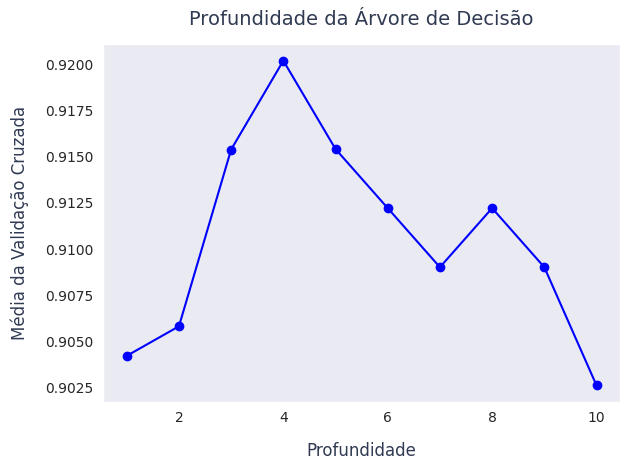

In [49]:
fig, ax = plt.subplots()

ax.plot(depths, mean_scores, 'b-o')
ax.set_xlabel('Profundidade', fontsize = 12, color = text, labelpad = 12)
ax.set_ylabel('Média da Validação Cruzada', fontsize = 12, color = text, labelpad = 12)
ax.set_title('Profundidade da Árvore de Decisão', fontsize = 14, color = text, pad = 14)

fig.tight_layout()
fig.show()

Dessa nossa análise, portanto, vemos que a profundidade ideal para a Árvore de Decisão será 4. Vamos então instanciar o modelo com o hiperparâmetro `max_depth` igual a 4.

In [50]:
# Instanciar o modelo
model_3 = DecisionTreeClassifier(max_depth = 4)

# Ajustar nos dados de treino 
model_3.fit(X_rus, y_rus)

# Realizar as previsões
y_pred_3 = model_3.predict(X_val)
y_proba_3 = model_3.predict_proba(X_val)

#### **Visualizando a Árvore de Decisão**

Para visualizar a Árvore de Decisão em si, iremos utilizar o `graphviz` e o `pydotplus`.

In [51]:
!pip install graphviz
!pip install pydotplus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


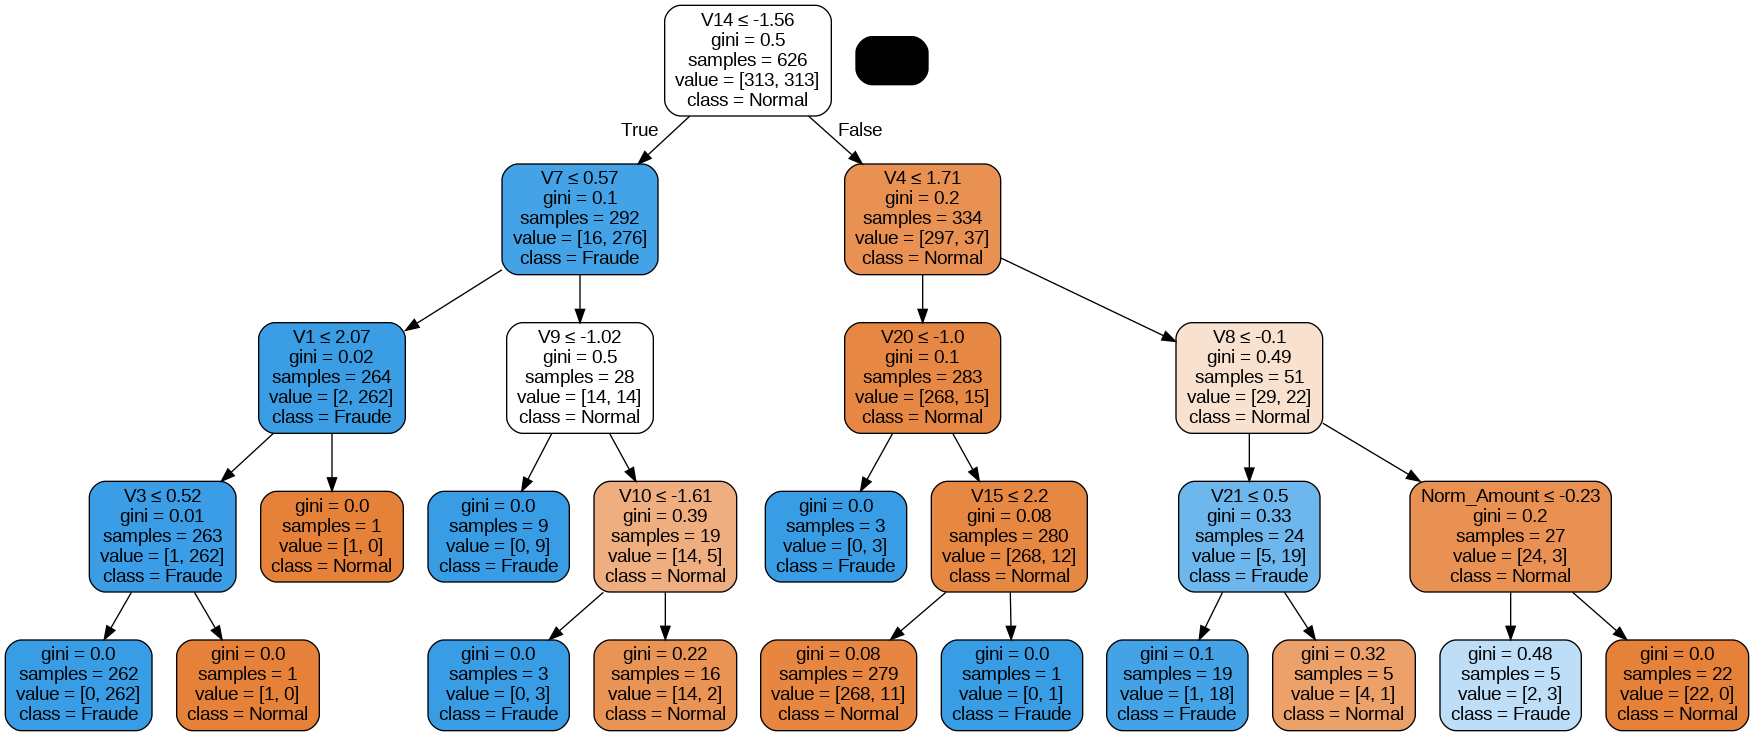

In [52]:
from sklearn.tree import export_graphviz
import graphviz
import pydotplus
from IPython.display import Image

dot_data = export_graphviz(model_3, out_file = None, 
                           feature_names = X.columns.tolist(), 
                           class_names = ['Normal', 'Fraude'],
                           filled = True, rounded = True,
                           precision = 2, special_characters = True)

graph = pydotplus.graph_from_dot_data(dot_data)
graphviz_graph = graphviz.Source(graph.to_string())
graphviz_graph.format = 'png'

filename = 'Árvore_de_Decisão.png'
graphviz_graph.render(filename, format = 'png')
Image(filename)
Image(graphviz_graph.pipe(format='png'))

#### **Matriz de confusão para a Árvore de Decisão**

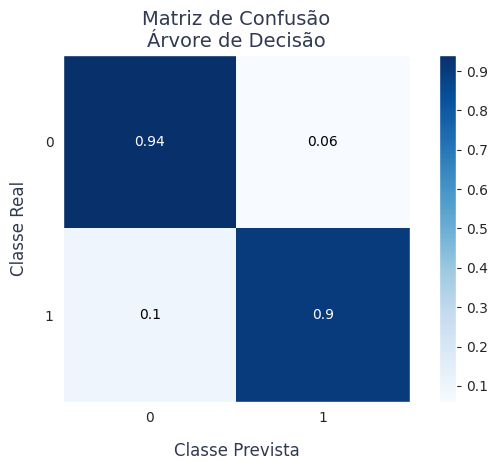

In [53]:
fig, ax = plt.subplots()

skplt.metrics.plot_confusion_matrix(y_val, y_pred_3, normalize = True, ax = ax)
ax.set_xlabel('Classe Prevista', fontsize = 12, color = text, labelpad = 12)
ax.set_ylabel('Classe Real', fontsize = 12, color = text, labelpad = 12)
ax.set_title('Matriz de Confusão\nÁrvore de Decisão', fontsize = 14, color = text)

fig.tight_layout()
fig.show()

A matriz de confusão para a Árvore de Decisão mostra que o modelo conseguiu classificar mais transações fraudulentas corretamente, se comparado com o modelo de regressão logística. Isto significa que o número de Falsos Negativos (FN) diminuiu e que o modelo pode servir como uma boa alternativa para o primeiro, caso a empresa prefira mitigar os efeitos das fraudes não identificadas.

O relatório de classificação a seguir mostra que a Árvore de Decisão tem uma ótima acurácia e capacidade de distinguir as classes corretamente, segundo a métrica da área sob a curva (AUC).

In [54]:
print('Relatório de Classificação:\n\n',
      classification_report(y_val, y_pred_3, digits = 3))

print('Acurácia:\t{:.3f}'.format(accuracy_score(y_val, y_pred_3)))
print('\nAUC:\t\t{:.3f}'.format(roc_auc_score(y_val, y_pred_3)))

Relatório de Classificação:

               precision    recall  f1-score   support

           0      1.000     0.938     0.968     45492
           1      0.024     0.897     0.047        78

    accuracy                          0.938     45570
   macro avg      0.512     0.918     0.508     45570
weighted avg      0.998     0.938     0.967     45570

Acurácia:	0.938

AUC:		0.918


## Avaliando os modelos no conjunto de teste

No início do projeto, reservamos 20% do _dataset_ para ser um conjunto de dados de teste, com exemplos totalmente novos para alimentar os modelos. Agora, iremos avaliar as métricas de desempenho dos modelos de regressão logística e de árvore de decisão sobre esses dados de teste.

In [55]:
print('Dimensões do conjunto de testes:\t', test.shape)

Dimensões do conjunto de testes:	 (56961, 31)


In [56]:
test.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
183484,125821.0,-0.323334,1.057455,-0.048341,-0.607204,1.259821,-0.091761,1.159101,-0.124335,-0.174640,...,-0.207098,-0.433890,-0.261613,-0.046651,0.211512,0.008297,0.108494,0.161139,40.00,0
255448,157235.0,-0.349718,0.932619,0.142992,-0.657071,1.169784,-0.733369,1.009985,-0.071069,-0.302083,...,-0.271537,-0.833209,-0.030360,0.490035,-0.404816,0.134350,0.076830,0.175562,1.98,0
244749,152471.0,-1.614711,-2.406570,0.326194,0.665520,2.369268,-1.775367,-1.139049,0.329904,0.903813,...,0.701399,1.134489,0.965054,0.640981,-1.801998,-1.041114,0.286285,0.437322,96.00,0


Note, porém, que antes precisaremos realizar a normalização das variáveis `Time` e `Amount`, da mesma forma como fizemos para os conjuntos de treino e validação. Para isso, vamos utilizar o mesmo método com o `RobustScaler`.

In [57]:
from sklearn.preprocessing import RobustScaler

test_clean = test.copy()

rob_scaler = RobustScaler()

# Normalizar os dados de teste
test_clean['Norm_Time'] = rob_scaler.fit_transform(test_clean['Time'].values.reshape(-1, 1))
test_clean['Norm_Amount'] = rob_scaler.fit_transform(test_clean['Amount'].values.reshape(-1, 1))

test_clean.drop(['Time', 'Amount'], axis = 1, inplace = True)

norm_time = test_clean['Norm_Time']
norm_amount = test_clean['Norm_Amount']

test_clean.drop(['Norm_Time', 'Norm_Amount'], axis = 1, inplace = True)

test_clean.insert(0, 'Norm_Time', norm_time)
test_clean.insert(1, 'Norm_Amount', norm_amount)

test_clean.head(3)

,Norm_Time,Norm_Amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
183484,0.484792,0.256025,-0.323334,1.057455,-0.048341,-0.607204,1.259821,-0.091761,1.159101,-0.124335,...,0.186409,-0.207098,-0.433890,-0.261613,-0.046651,0.211512,0.008297,0.108494,0.161139,0
255448,0.854138,-0.282960,-0.349718,0.932619,0.142992,-0.657071,1.169784,-0.733369,1.009985,-0.071069,...,-0.096502,-0.271537,-0.833209,-0.030360,0.490035,-0.404816,0.134350,0.076830,0.175562,0
244749,0.798126,1.049901,-1.614711,-2.406570,0.326194,0.665520,2.369268,-1.775367,-1.139049,0.329904,...,0.419835,0.701399,1.134489,0.965054,0.640981,-1.801998,-1.041114,0.286285,0.437322,0


In [58]:
# Dividindo os dados entre matriz de atributos e variável-alvo
X_test = test_clean.drop(['Class'], axis = 1)
y_test = test_clean['Class']

In [59]:
# Previsões a partir do modelo de regressão logística
y_test_pred_1 = model_1.predict(X_test)
y_test_proba_1 = model_1.predict_proba(X_test)

# Previsões a partir do modelo de árvore de decisão
y_test_pred_2 = model_3.predict(X_test)

### Matriz de Confusão - Dados de Teste

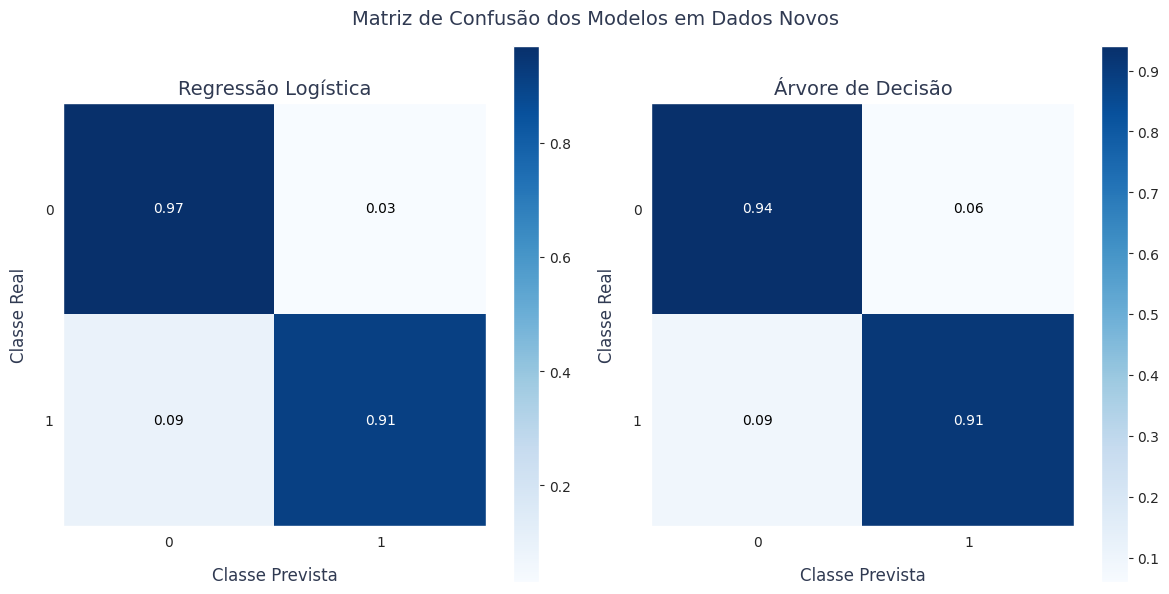

In [60]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))

skplt.metrics.plot_confusion_matrix(y_test, y_test_pred_1, normalize = True, ax = ax[0])
skplt.metrics.plot_confusion_matrix(y_test, y_test_pred_2, normalize = True, ax = ax[1])

ax[0].set_xlabel('Classe Prevista', fontsize = 12, color = text, labelpad = 12)
ax[0].set_ylabel('Classe Real', fontsize = 12, color = text, labelpad = 12)
ax[0].set_title('Regressão Logística', fontsize = 14, color = text)


ax[1].set_xlabel('Classe Prevista', fontsize = 12, color = text, labelpad = 12)
ax[1].set_ylabel('Classe Real', fontsize = 12, color = text, labelpad = 12)
ax[1].set_title('Árvore de Decisão', fontsize = 14, color = text)


fig.suptitle('Matriz de Confusão dos Modelos em Dados Novos', fontsize = 14, color = text)
fig.tight_layout()
fig.show()

### Relatório de Classificação Final - Regressão Logística

In [61]:
print('Relatório de classificação:\n\n',
      classification_report(y_test, y_test_pred_1, digits = 3))

print('Acurácia:\t{:.3f}'.format(accuracy_score(y_test, y_test_pred_1)))
print('\nAUC:\t\t{:.3f}'.format(roc_auc_score(y_test, y_test_pred_1)))
print('\nLog Loss:\t{:.3f}'.format(log_loss(y_test, y_test_pred_1)))

Relatório de classificação:

               precision    recall  f1-score   support

           0      1.000     0.968     0.984     56860
           1      0.048     0.911     0.092       101

    accuracy                          0.968     56961
   macro avg      0.524     0.939     0.538     56961
weighted avg      0.998     0.968     0.982     56961

Acurácia:	0.968

AUC:		0.939

Log Loss:	1.155


### Relatório de Classificação Final - Árvore de Decisão

In [62]:
print('Relatório de classificação:\n\n',
      classification_report(y_test, y_test_pred_2))

print('Acurácia:\t{:.3f}'.format(accuracy_score(y_test, y_test_pred_2)))
print('\nAUC:\t\t{:.3f}'.format(roc_auc_score(y_test, y_test_pred_2)))

Relatório de classificação:

               precision    recall  f1-score   support

           0       1.00      0.94      0.97     56860
           1       0.03      0.91      0.05       101

    accuracy                           0.94     56961
   macro avg       0.51      0.92      0.51     56961
weighted avg       1.00      0.94      0.97     56961

Acurácia:	0.938

AUC:		0.925




## Conclusão